In [283]:
import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns=1000
pd.options.display.max_rows=10

In [2]:
app_train = pd.read_csv('C://Users/matth/home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True)
app_test = pd.read_csv('C://Users/matth/home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True)

In [280]:
app_train.shape,app_test.shape

((307511, 122), (48744, 121))

In [5]:
app=app_train.append(app_test,ignore_index=True)
app=app.drop("SK_ID_CURR",axis=1)

In [54]:
categorical_features=app.select_dtypes(include="object").columns
unique_values=[len(app[x].unique()) for x in categorical_features]

In [83]:
label_encoding=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[:8].index

In [89]:
get_dummies=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[8:].index

In [109]:
pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[8:]

,Number of unique
NAME_EDUCATION_TYPE,5
FONDKAPREMONT_MODE,5
HOUSETYPE_MODE,4
CODE_GENDER,3
EMERGENCYSTATE_MODE,3
NAME_CONTRACT_TYPE,2
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2


In [96]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for c in label_encoding:
    le.fit(list(app[c].values))
    app[c]=le.transform(list(app[c].values))

In [115]:
app=pd.get_dummies(app,drop_first=True)

In [157]:
correlations=app.corr()["TARGET"]

In [158]:
correlations=pd.DataFrame(correlations)
correlations["TARGET abs"]=abs(correlations["TARGET"])

In [159]:
correlations=correlations.sort_values(by="TARGET abs",ascending=False)

In [160]:
correlations

,TARGET,TARGET abs
TARGET,1.000000,1.000000
EXT_SOURCE_3,-0.178919,0.178919
EXT_SOURCE_2,-0.160472,0.160472
EXT_SOURCE_1,-0.155317,0.155317
DAYS_BIRTH,0.078239,0.078239
...,...,...
FLAG_DOCUMENT_12,-0.000756,0.000756
FLAG_MOBIL,0.000534,0.000534
FLAG_CONT_MOBILE,0.000370,0.000370
FLAG_DOCUMENT_5,-0.000316,0.000316


In [237]:
relevant_features=correlations.index[1:15]

In [275]:
missing_data=[app[x].isna().sum()/len(app[x]) for x in relevant_features if app[x].isna().sum()!=0]
missing_cols=[x for x in relevant_features if app[x].isna().sum()!=0]
missing_data=pd.DataFrame(data=missing_data,index=missing_cols,columns=["% of missing data"])
missing_data=missing_data.sort_values(by="% of missing data",ascending=False)
missing_data

,% of missing data


In [171]:
ext1_corr=app.corr()["EXT_SOURCE_1"]

In [175]:
abs(pd.DataFrame(ext1_corr)).sort_values(by="EXT_SOURCE_1", ascending=False)

,EXT_SOURCE_1
EXT_SOURCE_1,1.000000
DAYS_BIRTH,0.586844
CODE_GENDER_M,0.302433
FLAG_EMP_PHONE,0.284973
DAYS_EMPLOYED,0.280783
...,...
HOUSETYPE_MODE_terraced house,0.000729
LANDAREA_MODE,0.000518
CODE_GENDER_XNA,0.000452
FLAG_DOCUMENT_16,0.000094


In [190]:
missing_ext1_rows= app[app["EXT_SOURCE_1"].isna()].index

In [210]:
#This takes 100 years
for x in missing_ext1_rows:
    app.loc[x,"EXT_SOURCE_1"]=app[(app["DAYS_BIRTH"]==app.loc[x,"DAYS_BIRTH"]) & (app["CODE_GENDER_M"]==app.loc[x,"CODE_GENDER_M"])]\
    ["EXT_SOURCE_1"].median()

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [219]:
app["EXT_SOURCE_1"].fillna(app["EXT_SOURCE_1"].median(),inplace=True)

In [226]:
app["DAYS_LAST_PHONE_CHANGE"].fillna(app["DAYS_LAST_PHONE_CHANGE"].median(),inplace=True)

In [245]:
ext2_corr=app.corr()["EXT_SOURCE_2"]

In [246]:
abs(pd.DataFrame(ext2_corr)).sort_values(by="EXT_SOURCE_2", ascending=False)

,EXT_SOURCE_2
EXT_SOURCE_2,1.000000
REGION_RATING_CLIENT,0.296715
REGION_RATING_CLIENT_W_CITY,0.291888
REGION_POPULATION_RELATIVE,0.201630
DAYS_LAST_PHONE_CHANGE,0.198574
...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.000605
FLAG_DOCUMENT_20,0.000519
FLAG_DOCUMENT_7,0.000449
CNT_FAM_MEMBERS,0.000435


In [247]:
missing_ext2_rows= app[app["EXT_SOURCE_2"].isna()].index

In [252]:
#This takes 100 years
for x in missing_ext2_rows:
    app.loc[x,"EXT_SOURCE_2"]=app[(app["REGION_RATING_CLIENT"]==app.loc[x,"REGION_RATING_CLIENT"]) & (app["REGION_RATING_CLIENT_W_CITY"]==app.loc[x,"REGION_RATING_CLIENT_W_CITY"])]\
    ["EXT_SOURCE_2"].median()

In [274]:
app["EXT_SOURCE_3"].fillna(app["EXT_SOURCE_3"].median(),inplace=True)

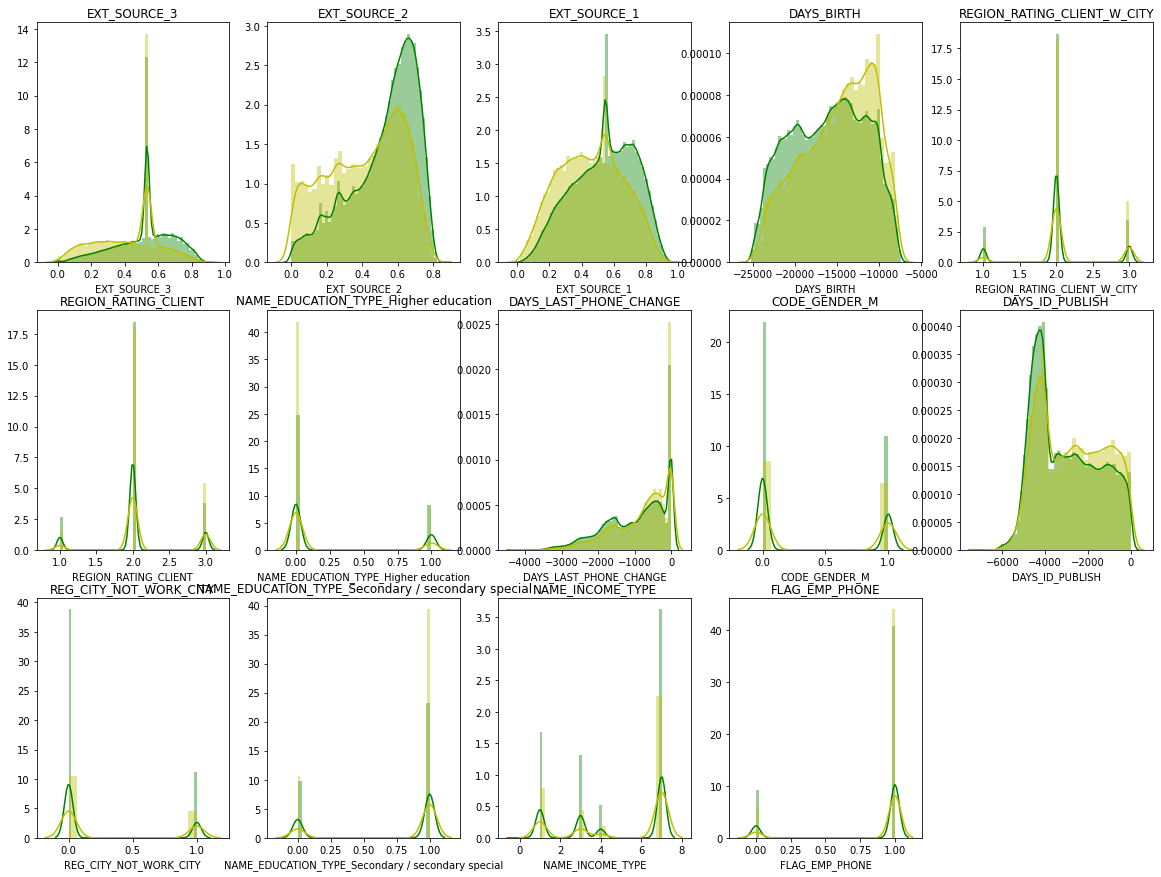

In [293]:
plt.figure(figsize=(20,15))
counter=1
for x in relevant_features:
    plt.subplot(3,5,counter)
    sns.distplot(app[app["TARGET"]==0][x],color="g",label="non-default")
    sns.distplot(app[app["TARGET"]==1][x],color="y",label="default")
    plt.title(x)
    counter+=1

In [292]:
plt.figure(figsize=(20,15))
counter=1
for x in relevant_features:
    sns.b

In [297]:
sns.boxplot?